In [16]:
import numpy as np
import pandas as pd

In [17]:
df = pd.read_csv("ML-EdgeIIoT-dataset.csv", low_memory = False).sample(10000)

In [18]:
df.shape

(10000, 63)

In [19]:
df.dropna(axis = 1, inplace = True)
df.shape

(10000, 63)

In [20]:
# Dropping the unnecessary attributes
df.drop(["frame.time", "http.file_data", "http.content_length", "http.request.uri.query",
"http.request.method", "http.referer", "http.request.full_uri",
"http.request.version", "http.response", "http.tls_port", "dns.qry.name", "dns.qry.name.len", "dns.qry.qu",
"dns.qry.type", "dns.retransmission", "dns.retransmit_request",
"dns.retransmit_request_in", "mqtt.conack.flags",
"mqtt.conflag.cleansess", "mqtt.conflags", "mqtt.hdrflags", "mqtt.len",
"mqtt.msg_decoded_as", "mqtt.msg", "mqtt.msgtype", "mqtt.proto_len",
"mqtt.protoname", "mqtt.topic", "mqtt.topic_len", "mqtt.ver","tcp.connection.fin",
"tcp.connection.rst", "tcp.connection.syn", "tcp.connection.synack",
"tcp.dstport", "tcp.flags", "tcp.flags.ack", "tcp.len", "tcp.options",
"tcp.payload", "tcp.seq", "tcp.srcport"
], inplace = True, axis = 1)

In [21]:
df_labels = df[["Attack_label"]]
df_types = df[["Attack_type"]]

In [22]:
# Converting the ip.src_host to int
import ipaddress
def ip_to_int(ip_address):
  try:
    return int(ipaddress.IPv4Address(ip_address))
  except:
    if (ip_address == "0.0") or (ip_address == "0"):
      return 0
    else:
      return np.nan

df["ip.src_host"] = df["ip.src_host"].apply(ip_to_int)
df["arp.dst.proto_ipv4"] = df["arp.dst.proto_ipv4"].apply(ip_to_int)
df["arp.src.proto_ipv4"] = df["arp.src.proto_ipv4"].apply(ip_to_int)
df["ip.dst_host"] = df["ip.dst_host"].apply(ip_to_int)

In [23]:
df.dtypes

ip.src_host                  int64
ip.dst_host                  int64
arp.dst.proto_ipv4           int64
arp.opcode                 float64
arp.hw.size                float64
arp.src.proto_ipv4           int64
icmp.checksum              float64
icmp.seq_le                float64
icmp.transmit_timestamp    float64
icmp.unused                float64
tcp.ack                    float64
tcp.ack_raw                float64
tcp.checksum               float64
udp.port                   float64
udp.stream                 float64
udp.time_delta             float64
mbtcp.len                  float64
mbtcp.trans_id             float64
mbtcp.unit_id              float64
Attack_label                 int64
Attack_type                 object
dtype: object

# binary class modelling

* Feature importance

In [24]:
from sklearn.model_selection import train_test_split
X, y = df.drop(["Attack_label", "Attack_type"], axis = 1), df["Attack_label"]
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [25]:
from sklearn.ensemble import RandomForestClassifier
model_bin = RandomForestClassifier(n_estimators = 100, random_state = 42)
model_bin.fit(X_train_bin, y_train_bin)
importance = model_bin.feature_importances_
df_imp_bin = pd.DataFrame({"feature": X_train_bin.columns, "importance": importance})
df_imp_bin.sort_values(by = "importance", ascending = False)

,feature,importance
1,ip.dst_host,0.331545
0,ip.src_host,0.262119
10,tcp.ack,0.226776
11,tcp.ack_raw,0.074772
12,tcp.checksum,0.069373
14,udp.stream,0.012566
7,icmp.seq_le,0.011330
6,icmp.checksum,0.008771
15,udp.time_delta,0.000724
2,arp.dst.proto_ipv4,0.000679


In [26]:
df_imp_bin = df_imp_bin[df_imp_bin["importance"] > 0.0001]
imp_bin_cols = [col for col in np.array(df_imp_bin["feature"])]
imp_bin_cols

['ip.src_host',
 'ip.dst_host',
 'arp.dst.proto_ipv4',
 'arp.opcode',
 'arp.src.proto_ipv4',
 'icmp.checksum',
 'icmp.seq_le',
 'tcp.ack',
 'tcp.ack_raw',
 'tcp.checksum',
 'udp.port',
 'udp.stream',
 'udp.time_delta']

In [27]:
df_imp_bin = df[imp_bin_cols]
df_imp_bin = pd.merge(df_imp_bin, df_labels, left_index = True, right_index = True)
df_imp_bin.dropna(axis = 1, inplace = True)
df_imp_bin

,ip.src_host,ip.dst_host,arp.dst.proto_ipv4,arp.opcode,arp.src.proto_ipv4,icmp.checksum,icmp.seq_le,tcp.ack,tcp.ack_raw,tcp.checksum,udp.port,udp.stream,udp.time_delta,Attack_label
48062,3232235648,773784830,0,0.0,0,0.0,0.0,121.0,2.072018e+09,2668.0,0.0,0.0,0.0,1
32389,3232235690,3232235648,0,0.0,0,0.0,0.0,478.0,3.682361e+09,16414.0,0.0,0.0,0.0,1
118828,3232235621,3232235648,0,0.0,0,0.0,0.0,5.0,4.021399e+09,38275.0,0.0,0.0,0.0,0
118661,3232235648,3232235621,0,0.0,0,0.0,0.0,15.0,2.886442e+09,14554.0,0.0,0.0,0.0,0
127892,3232235621,3232235648,0,0.0,0,0.0,0.0,6.0,2.024372e+09,10480.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39396,3232235648,3232235690,0,0.0,0,0.0,0.0,817.0,1.046882e+09,65456.0,0.0,0.0,0.0,1
149996,1913331982,3232235648,0,0.0,0,10240.0,63624.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,1
122348,3232235648,3232235621,0,0.0,0,0.0,0.0,15.0,2.603491e+09,32214.0,0.0,0.0,0.0,0
66162,0,0,3232235667,1.0,3232235521,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,1


In [31]:
# oversample the data for most accuracy
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(sampling_strategy = "auto")
X_resampled_bin, y_resampled_bin = ros.fit_resample(X, y)

In [32]:
X, y = df_imp_bin.drop("Attack_label", axis = 1), df_imp_bin["Attack_label"]
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_resampled_bin, y_resampled_bin, test_size = 0.3, random_state = 42)

<Axes: ylabel='count'>

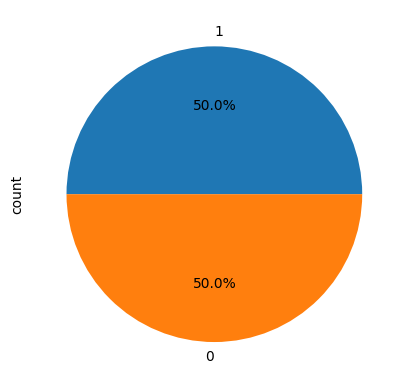

In [33]:
y_resampled_bin.value_counts().plot.pie(autopct = "%0.1f%%")

from our previous observations we seen that knn, svc, logistic_reg are candidates to apply bagging

In [34]:
# apply the bagging

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

bagging_knn = BaggingClassifier(KNeighborsClassifier(n_neighbors = 5), n_estimators = 50, max_samples = 0.8, bootstrap = True, n_jobs = -1)
bagging_svc = BaggingClassifier(SVC(C = 0.1, kernel = "sigmoid", max_iter = 10000), n_estimators = 10, max_samples = 0.8, bootstrap = True, n_jobs = -1)
bagging_lr = BaggingClassifier(LogisticRegression(C = 0.1, max_iter = 10000), n_estimators = 50, max_samples = 0.8, bootstrap = True, n_jobs = -1)
bagging_rf = BaggingClassifier(RandomForestClassifier(n_estimators = 100, random_state = 42), n_estimators = 50, max_samples = 0.8, bootstrap = True, n_jobs = -1)
bagging_nb = BaggingClassifier(GaussianNB(), n_estimators = 50, max_samples = 0.8, bootstrap = True, n_jobs = -1)

models = []
models.append((bagging_knn, "KNN"))
models.append((bagging_svc, "SVC"))
models.append((bagging_lr, "LR"))
models.append((bagging_rf, "RF"))
models.append((bagging_nb, "NB"))

print("Do you want to print classification_report(0, 1): ")
choice = int(input())
for bagger, name in models:
  print("training: ", name)
  bagger.fit(X_resampled_bin, y_resampled_bin)
  print(name, bagger.score(X_test_bin, y_test_bin))
  if choice == 1:
    print(classification_report(y_test_bin, bagger.predict(X_test_bin)))
  print("-" * 40)

Do you want to print classification_report(0, 1): 
training:  KNN
KNN 0.8869000786782061
              precision    recall  f1-score   support

           0       0.82      0.99      0.90      2492
           1       0.99      0.79      0.88      2592

    accuracy                           0.89      5084
   macro avg       0.90      0.89      0.89      5084
weighted avg       0.90      0.89      0.89      5084

----------------------------------------
training:  SVC
SVC 0.44256490952006294
              precision    recall  f1-score   support

           0       0.43      0.45      0.44      2492
           1       0.45      0.44      0.45      2592

    accuracy                           0.44      5084
   macro avg       0.44      0.44      0.44      5084
weighted avg       0.44      0.44      0.44      5084

----------------------------------------
training:  LR
LR 0.6138867033831629
              precision    recall  f1-score   support

           0       0.58      0.75      0.66  

# Multiclass modelling

* Feature importance

In [63]:
from sklearn.model_selection import train_test_split
X, y = df.drop(["Attack_label", "Attack_type"], axis = 1), df["Attack_type"]
X_train_type, X_test_type, y_train_type, y_test_type = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [64]:
from sklearn.ensemble import RandomForestClassifier
model_type = RandomForestClassifier(n_estimators = 100, random_state = 42)
model_type.fit(X_train_type, y_train_type)
importance = model_type.feature_importances_
df_imp_type = pd.DataFrame({"feature": X_train_type.columns, "importance": importance})
df_imp_type.sort_values(by = "importance", ascending = False)

,feature,importance
10,tcp.ack,0.265093
11,tcp.ack_raw,0.200970
12,tcp.checksum,0.177057
0,ip.src_host,0.106952
1,ip.dst_host,0.099402
14,udp.stream,0.060922
7,icmp.seq_le,0.039796
6,icmp.checksum,0.039106
2,arp.dst.proto_ipv4,0.002925
3,arp.opcode,0.002342


In [65]:
df_imp_type = df_imp_type[df_imp_type["importance"] > 0.0001]
imp_type_cols = [col for col in np.array(df_imp_type["feature"])]
imp_type_cols

['ip.src_host',
 'ip.dst_host',
 'arp.dst.proto_ipv4',
 'arp.opcode',
 'arp.hw.size',
 'arp.src.proto_ipv4',
 'icmp.checksum',
 'icmp.seq_le',
 'icmp.transmit_timestamp',
 'tcp.ack',
 'tcp.ack_raw',
 'tcp.checksum',
 'udp.port',
 'udp.stream',
 'udp.time_delta']

In [66]:
df_imp_type = df[imp_type_cols]
df_imp_type = pd.merge(df_imp_type, df_types, left_index = True, right_index = True)
df_imp_type.dropna(axis = 1, inplace = True)
df_imp_type

,ip.src_host,ip.dst_host,arp.dst.proto_ipv4,arp.opcode,arp.hw.size,arp.src.proto_ipv4,icmp.checksum,icmp.seq_le,icmp.transmit_timestamp,tcp.ack,tcp.ack_raw,tcp.checksum,udp.port,udp.stream,udp.time_delta,Attack_type
48062,3232235648,773784830,0,0.0,0.0,0,0.0,0.0,0.0,121.0,2.072018e+09,2668.0,0.0,0.0,0.0,DDoS_TCP
32389,3232235690,3232235648,0,0.0,0.0,0,0.0,0.0,0.0,478.0,3.682361e+09,16414.0,0.0,0.0,0.0,SQL_injection
118828,3232235621,3232235648,0,0.0,0.0,0,0.0,0.0,0.0,5.0,4.021399e+09,38275.0,0.0,0.0,0.0,Normal
118661,3232235648,3232235621,0,0.0,0.0,0,0.0,0.0,0.0,15.0,2.886442e+09,14554.0,0.0,0.0,0.0,Normal
127892,3232235621,3232235648,0,0.0,0.0,0,0.0,0.0,0.0,6.0,2.024372e+09,10480.0,0.0,0.0,0.0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39396,3232235648,3232235690,0,0.0,0.0,0,0.0,0.0,0.0,817.0,1.046882e+09,65456.0,0.0,0.0,0.0,DDoS_HTTP
149996,1913331982,3232235648,0,0.0,0.0,0,10240.0,63624.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,DDoS_ICMP
122348,3232235648,3232235621,0,0.0,0.0,0,0.0,0.0,0.0,15.0,2.603491e+09,32214.0,0.0,0.0,0.0,Normal
66162,0,0,3232235667,1.0,6.0,3232235521,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,Port_Scanning


oversampling

In [67]:
# oversample the data for most accuracy
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(sampling_strategy = "auto")
X_resampled_type, y_resampled_type = ros.fit_resample(X_train_type, y_train_type)

In [68]:
X, y = df_imp_type.drop("Attack_type", axis = 1), df_imp_type["Attack_type"]
X_train_type, X_test_type, y_train_type, y_test_type = train_test_split(X_resampled_type, y_resampled_type, test_size = 0.3, random_state = 42)

<Axes: ylabel='count'>

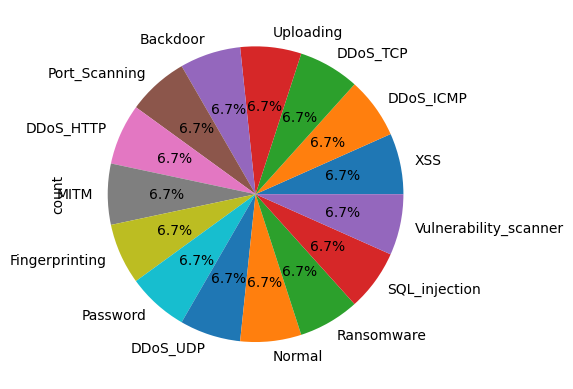

In [69]:
y_resampled_type.value_counts().plot.pie(autopct = "%0.1f%%")

In [42]:
y_resampled_type.unique()

array(['XSS', 'DDoS_ICMP', 'DDoS_TCP', 'Uploading', 'Backdoor',
       'Port_Scanning', 'DDoS_HTTP', 'MITM', 'Fingerprinting', 'Password',
       'DDoS_UDP', 'Normal', 'Ransomware', 'SQL_injection',
       'Vulnerability_scanner'], dtype=object)

In [47]:
# apply the bagging

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

bagging_knn = BaggingClassifier(KNeighborsClassifier(n_neighbors = 5), n_estimators = 20, max_samples = 0.8, bootstrap = True, n_jobs = -1)
# bagging_svc = BaggingClassifier(SVC(C = 0.1, kernel = "sigmoid", max_iter = 10000), n_estimators = 50, max_samples = 0.8, bootstrap = True, n_jobs = -1)
# bagging_lr = BaggingClassifier(LogisticRegression(C = 0.1, max_iter = 10000), n_estimators = 20, max_samples = 0.8, bootstrap = True, n_jobs = -1)
bagging_rf = BaggingClassifier(RandomForestClassifier(n_estimators = 100, random_state = 42), n_estimators = 50, max_samples = 0.8, bootstrap = True, n_jobs = -1)
bagging_nb = BaggingClassifier(GaussianNB(), n_estimators = 20, max_samples = 0.8, bootstrap = True, n_jobs = -1)

models = []
models.append((bagging_knn, "KNN"))
# models.append((bagging_svc, "SVC"))
# models.append((bagging_lr, "LR"))
models.append((bagging_rf, "RF"))
models.append((bagging_nb, "NB"))

print("Do you want to print classification_report(0, 1): ")
choice = int(input())
for bagger, name in models:
  print("training: ", name)
  bagger.fit(X_resampled_type, y_resampled_type)
  print(name, bagger.score(X_test_type, y_test_type))
  if choice == 1:
    print(classification_report(y_test_type, bagger.predict(X_test_type)))
  print("-" * 40)

Do you want to print classification_report(0, 1): 
training:  KNN
KNN 0.8148148148148148
                       precision    recall  f1-score   support

             Backdoor       0.97      0.94      0.96       303
            DDoS_HTTP       0.69      0.65      0.67       331
            DDoS_ICMP       0.97      1.00      0.98       318
             DDoS_TCP       0.99      0.93      0.96       318
             DDoS_UDP       1.00      1.00      1.00       303
       Fingerprinting       0.91      0.98      0.95       318
                 MITM       0.89      1.00      0.94       313
               Normal       0.73      0.34      0.47       315
             Password       0.70      0.76      0.73       320
        Port_Scanning       0.81      0.76      0.78       331
           Ransomware       0.97      0.90      0.93       312
        SQL_injection       0.63      0.75      0.69       299
            Uploading       0.64      0.74      0.68       297
Vulnerability_scanner       

MemoryError: 

# Neural Network

In [96]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

* Binaryclass modelling

In [97]:
scaler = StandardScaler()
X_resampled_bin = scaler.fit_transform(X_resampled_bin)

In [99]:
model = Sequential([
    Input(shape = (X_resampled_bin.shape[1], )),
    Dense(128, activation = "relu"),
    Dense(64, activation = "relu"),
    Dense(1, activation = "sigmoid"),
])
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.fit(X_resampled_bin, y_resampled_bin, epochs = 100, batch_size = 16)

Epoch 1/100
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6487 - loss: 0.5533
Epoch 2/100
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6804 - loss: 0.5167
Epoch 3/100
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6787 - loss: 0.5146
Epoch 4/100
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6791 - loss: 0.5122
Epoch 5/100
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6897 - loss: 0.5084
Epoch 6/100
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6797 - loss: 0.5070
Epoch 7/100
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6827 - loss: 0.5098
Epoch 8/100
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6859 - loss: 0.5067
Epoch 9/100
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6814 - loss: 0.5083
Epoch 10/100
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6871 - loss: 0.5063
Epoch 11/100
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6850 - loss: 0.5073
Epoch 12/100
1059/1

KeyboardInterrupt: 

* Multiclass modelling

In [ ]:
X_resampled_type = scaler.fit_transform(X_resampled_type)

In [72]:
classes = []
label_encoder = LabelEncoder()
for x in y_resampled_type.unique():
  classes.append(x)
label_encoder.fit(classes)
y_resampled_type = label_encoder.transform(y_resampled_type)
class_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
for key, value in class_mapping.items():
  print(key, "->", value)

Backdoor -> 0
DDoS_HTTP -> 1
DDoS_ICMP -> 2
DDoS_TCP -> 3
DDoS_UDP -> 4
Fingerprinting -> 5
MITM -> 6
Normal -> 7
Password -> 8
Port_Scanning -> 9
Ransomware -> 10
SQL_injection -> 11
Uploading -> 12
Vulnerability_scanner -> 13
XSS -> 14


In [ ]:
one_hot_encoded_y_type = to_categorical(y_resampled_type, num_classes = 15)

In [86]:
len(np.unique(y_resampled_type))

15

In [95]:
model = Sequential([
    Input(shape = (X_resampled_type.shape[1], )),
    Dense(128, activation = "relu"),
    Dense(64, activation = "relu"),
    Dense(15, activation = "softmax"),
])
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.fit(X_resampled_type, one_hot_encoded_y_type , epochs = 100, batch_size = 32)

Epoch 1/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3295 - loss: 1.9920
Epoch 2/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4271 - loss: 1.6177
Epoch 3/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4413 - loss: 1.5557
Epoch 4/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4440 - loss: 1.5285
Epoch 5/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4554 - loss: 1.5081
Epoch 6/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4525 - loss: 1.5095
Epoch 7/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4610 - loss: 1.4794
Epoch 8/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4578 - loss: 1.4841
Epoch 9/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4656 - loss: 1.4684
Epoch 10/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4614 - loss: 1.4661
Epoch 11/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4594 - loss: 1.4685
Epoch 12/100
490/490 ━━━━━━━━━━━━━━━━━━━━